In [ ]:
import numpy as np
import pandas as pd
import time
import torch
import torch.nn as nn
from sklearn.preprocessing import OrdinalEncoder, StandardScaler, MinMaxScaler
from sklearn.metrics import mean_absolute_error, classification_report, roc_auc_score
from sklearn.model_selection import cross_val_score, ShuffleSplit, KFold
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.linear_model import LinearRegression, Ridge, Lasso, LogisticRegression
from tqdm.notebook import tqdm
from sklearn.utils import resample
from sklearn.neural_network import MLPRegressor
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor, AdaBoostRegressor, GradientBoostingRegressor, StackingRegressor
from nltk.corpus import stopwords
from sklearn.model_selection import GridSearchCV
from imblearn.over_sampling import SMOTE
from sklearn.decomposition import PCA
from xgboost import XGBRegressor
import nltk
from scipy.stats import binned_statistic
import seaborn as sn
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import matplotlib.pyplot as plt
from sklearn.svm import SVC, SVR
from random import random, randrange
from datetime import datetime
from sklearn.model_selection import train_test_split
nltk.download("stopwords")

/usr/local/lib/python3.7/dist-packages/sklearn/externals/six.py:31: FutureWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.neighbors.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.neighbors. Anything that cannot be imported from sklearn.neighbors is now part of the private API.
  warnings.warn(message, FutureWarning)


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [ ]:
!pip install kaggle
!pip install ta

  Created wheel for ta: filename=ta-0.7.0-cp37-none-any.whl size=28716 sha256=6cbc4a10e3f2217c39e2d49b542b7bebfb790f2d6f56802d4852046560a07db2
  Stored in directory: /root/.cache/pip/wheels/dd/88/30/de9553fb54a474eb7480b937cdbb140bdda613d29cf4da7994
Successfully built ta


In [ ]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"adelante4","key":"03ce7ef6b6693eea773f084c9340b5b9"}'}

In [ ]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

# Mobile Data

In [ ]:
!kaggle datasets download -d iabhishekofficial/mobile-price-classification

  0% 0.00/70.6k [00:00<?, ?B/s]
100% 70.6k/70.6k [00:00<00:00, 33.4MB/s]


## Data Preprocessing

In [ ]:
import zipfile
zip_ref = zipfile.ZipFile('mobile-price-classification.zip', 'r')
zip_ref.extractall('files')
zip_ref.close()
mobile_train=pd.read_csv('/content/files/train.csv')
mobile_test=pd.read_csv('/content/files/test.csv')

In [ ]:
mobile_train.head()

,battery_power,blue,clock_speed,dual_sim,fc,four_g,int_memory,m_dep,mobile_wt,n_cores,pc,px_height,px_width,ram,sc_h,sc_w,talk_time,three_g,touch_screen,wifi,price_range
0,842,0,2.2,0,1,0,7,0.6,188,2,2,20,756,2549,9,7,19,0,0,1,1
1,1021,1,0.5,1,0,1,53,0.7,136,3,6,905,1988,2631,17,3,7,1,1,0,2
2,563,1,0.5,1,2,1,41,0.9,145,5,6,1263,1716,2603,11,2,9,1,1,0,2
3,615,1,2.5,0,0,0,10,0.8,131,6,9,1216,1786,2769,16,8,11,1,0,0,2
4,1821,1,1.2,0,13,1,44,0.6,141,2,14,1208,1212,1411,8,2,15,1,1,0,1


In [ ]:
def prep_data(data):
  X_train = data[[c for c in data.columns if c != 'price_rance']].values
  y_train = data['price_range']

  X_train, X_test, y_train, y_test = train_test_split(X_train, y_train, test_size=0.8)

  X_scaler = StandardScaler()
  X_train = X_scaler.fit_transform(X_train)

  X_test = X_scaler.transform(X_test)

  return X_train, X_test, y_train, y_test

In [ ]:
X_train, X_test, y_train, y_test = prep_data(mobile_train)

## Training SVM with different parameters

In [ ]:
svm_linear = SVC(kernel='linear')
svm_linear = svm_linear.fit(X_train, y_train)

In [ ]:
svm_linear.score(X_test, y_test)

1.0

In [ ]:
svm_rbf_scale = SVC(kernel='rbf', gamma='scale')
svm_rbf_scale = svm_rbf_scale.fit(X_train, y_train)

In [ ]:
svm_rbf_scale.score(X_test, y_test)

0.995625

In [ ]:
svm_rbf_auto = SVC(kernel='rbf', gamma='auto')
svm_rbf_auto = svm_rbf_auto.fit(X_train, y_train)

In [ ]:
svm_rbf_auto.score(X_test, y_test)

0.995625

In [ ]:
svm_poly_2 = SVC(kernel='poly', degree=2)
svm_poly_2 = svm_poly_2.fit(X_train, y_train)

In [ ]:
svm_poly_2.score(X_test, y_test)

0.5025

In [ ]:
svm_poly_3 = SVC(kernel='poly', degree=3)
svm_poly_3 = svm_poly_3.fit(X_train, y_train)

In [ ]:
svm_poly_3.score(X_test, y_test)

0.795

In [ ]:
svm_sigmoid = SVC(kernel='sigmoid')
svm_sigmoid = svm_sigmoid.fit(X_train, y_train)

In [ ]:
svm_sigmoid.score(X_test, y_test)

1.0

### Soft and hard margin

In [ ]:
svm_linear = SVC(kernel='linear', C=0.1e-10)
svm_linear = svm_linear.fit(X_train, y_train)

In [ ]:
svm_linear.score(X_test, y_test)

0.24

In [ ]:
svm_linear = SVC(kernel='linear', C=100000000000000000000000000000)
svm_linear = svm_linear.fit(X_train, y_train)

In [ ]:
svm_linear.score(X_test, y_test)

1.0

## Data transformations

### Binning features

Text(0, 0.5, 'Frequency')

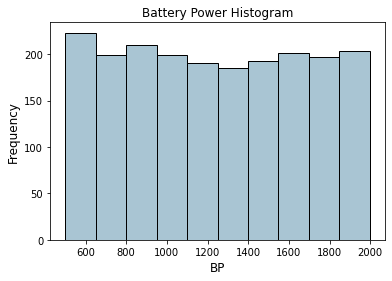

In [ ]:
fig, ax = plt.subplots()
mobile_train['battery_power'].hist(color='#A9C5D3', edgecolor='black',  
                          grid=False)
ax.set_title('Battery Power Histogram', fontsize=12)
ax.set_xlabel('BP', fontsize=12)
ax.set_ylabel('Frequency', fontsize=12)


#### Custom bins

In [ ]:
bin_ranges = [0, 650, 800, 950, 1100, 1250, 1400, 1550, 1700, 1850, 2000]
bin_names = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
BP_bin1_feature = pd.Series(pd.cut(
                                           np.array(
                                              mobile_train['battery_power']), 
                                              bins=bin_ranges, 
                                              labels=bin_names), name='BP_bin1')
BP_bin1 = pd.concat([mobile_train, BP_bin1_feature], axis=1)

In [ ]:
X_train, X_test, y_train, y_test = prep_data(BP_bin1)
svm_test = SVC(kernel='poly', degree=3)
svm_test = svm_test.fit(X_train, y_train)
svm_test.score(X_test, y_test)

0.79125

#### Custom bins

In [ ]:
bin_ranges = [0, 800, 1100, 1400, 1700, 2000]
bin_names = [1, 2, 3, 4, 5]
BP_bin2_feature = pd.Series(pd.cut(
                                           np.array(
                                              mobile_train['battery_power']), 
                                              bins=bin_ranges, 
                                              labels=bin_names), name='BP_bin2')
BP_bin2 = pd.concat([mobile_train, BP_bin2_feature], axis=1)

In [ ]:
X_train, X_test, y_train, y_test = prep_data(BP_bin2)
svm_test = SVC(kernel='poly', degree=3)
svm_test = svm_test.fit(X_train, y_train)
svm_test.score(X_test, y_test)

0.78375

#### Quantiles bins

Text(0, 0.5, 'Frequency')

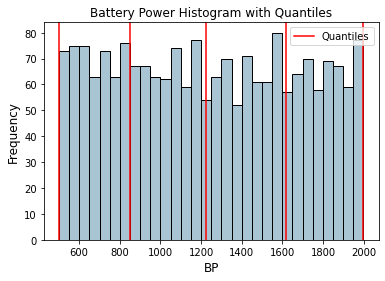

In [ ]:
quantiles = [0, .25, .5, .75, 1.]
quantiles = mobile_train['battery_power'].quantile(quantiles)

fig, ax = plt.subplots()
mobile_train['battery_power'].hist(bins=30, color='#A9C5D3', 
                             edgecolor='black', grid=False)
for quantile in quantiles:
    qvl = plt.axvline(quantile, color='r')
ax.legend([qvl], ['Quantiles'], fontsize=10)
ax.set_title('Battery Power Histogram with Quantiles', fontsize=12)
ax.set_xlabel('BP', fontsize=12)
ax.set_ylabel('Frequency', fontsize=12)

In [ ]:
bin_names = [1, 2, 3, 4]
BP_bin3_feature = pd.Series(pd.qcut(
                                            mobile_train['battery_power'], 
                                            q=[0, .25, .5, .75, 1.],       
                                            labels=bin_names), name='BP_bin3')
BP_bin3 = pd.concat([mobile_train, BP_bin3_feature], axis=1)

In [ ]:
X_train, X_test, y_train, y_test = prep_data(BP_bin3)
svm_test = SVC(kernel='poly', degree=3)
svm_test = svm_test.fit(X_train, y_train)
svm_test.score(X_test, y_test)

0.76375

### One-hot encoding

In [ ]:
def encode_and_bind(original_dataframe, feature_to_encode):
    dummies = pd.get_dummies(original_dataframe[feature_to_encode])
    res = pd.concat([original_dataframe, dummies], axis=1)
    res = res.drop([feature_to_encode], axis=1)
    return res, dummies 

In [ ]:
res, res_features = encode_and_bind(mobile_train, 'n_cores')

In [ ]:
X_train, X_test, y_train, y_test = prep_data(res)
svm_test = SVC(kernel='poly', degree=3)
svm_test = svm_test.fit(X_train, y_train)
svm_test.score(X_test, y_test)

0.71375

### Log transform

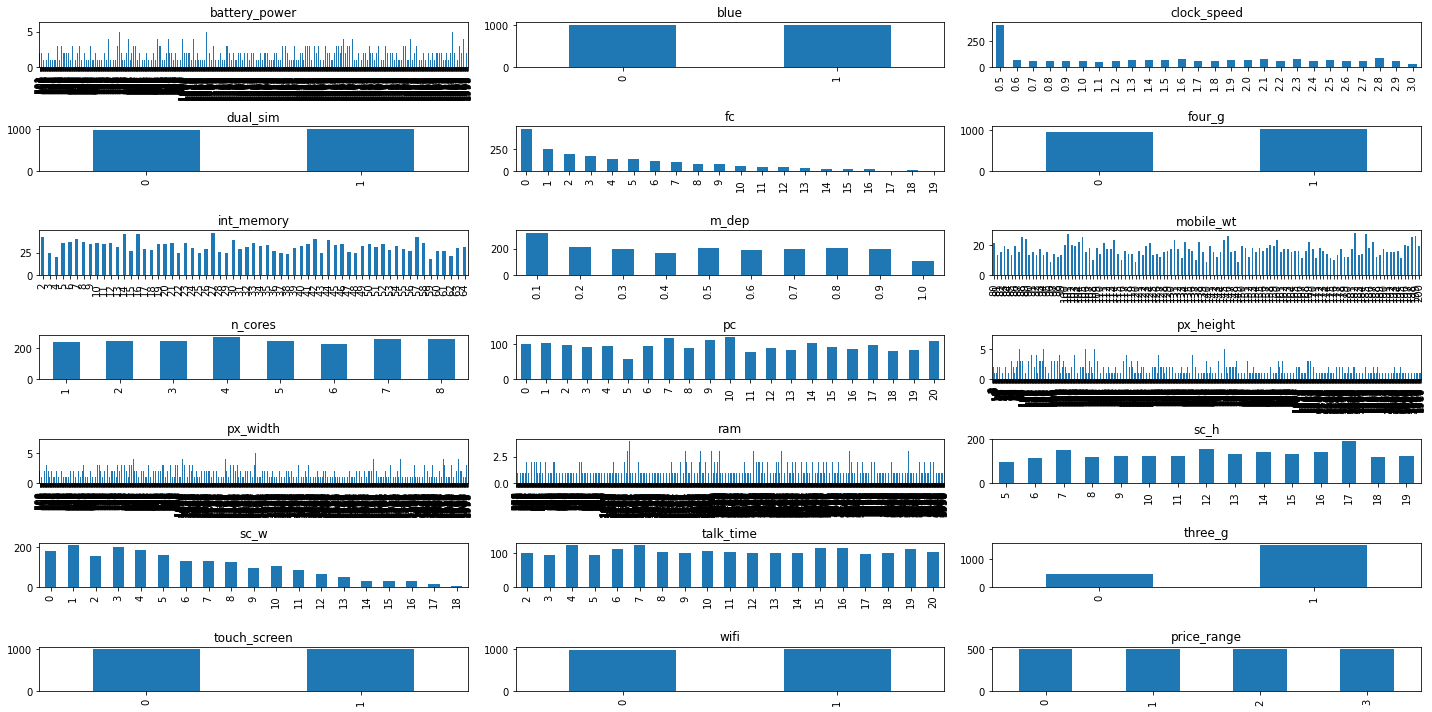

In [ ]:
fig, axes = plt.subplots(nrows=int(len(mobile_train.columns)/3), ncols=3, figsize=(20,10))
for col, ax in zip(mobile_train, axes.ravel()):
    mobile_train[col].value_counts().sort_index().plot.bar(ax=ax, title=col)

plt.tight_layout()    
plt.show()

In [ ]:
fc_log_feature = pd.Series(np.log((1+ mobile_train['fc'])), name='fc_log')
fc_log = pd.concat([mobile_train, fc_log_feature], axis=1).drop(['fc'], axis=1)

Text(0, 0.5, 'Frequency')

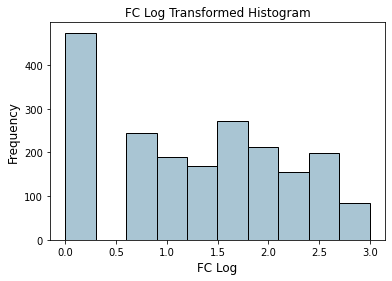

In [ ]:
fig, ax = plt.subplots()
fc_log['fc_log'].hist(color='#A9C5D3', edgecolor='black',  
                          grid=False)
ax.set_title('FC Log Transformed Histogram', fontsize=12)
ax.set_xlabel('FC Log', fontsize=12)
ax.set_ylabel('Frequency', fontsize=12)


In [ ]:
X_train, X_test, y_train, y_test = prep_data(fc_log)
svm_test = SVC(kernel='poly', degree=3)
svm_test = svm_test.fit(X_train, y_train)
svm_test.score(X_test, y_test)

0.831875

### Adding area

In [ ]:
area_feature = pd.Series(mobile_train['px_height']*mobile_train['px_width'], name='area')
area = pd.concat([mobile_train, area_feature], axis=1)

In [ ]:
X_train, X_test, y_train, y_test = prep_data(area)
svm_test = SVC(kernel='poly', degree=3)
svm_test = svm_test.fit(X_train, y_train)
svm_test.score(X_test, y_test)

0.798125

### All tranformations together

In [ ]:
final = pd.concat([area_feature, fc_log_feature, res_features, BP_bin1_feature, BP_bin2_feature, BP_bin3_feature, mobile_train], axis=1).drop(['n_cores', 'fc'], axis=1)
X_train, X_test, y_train, y_test = prep_data(final)
svm_test = SVC(kernel='poly', degree=3)
svm_test = svm_test.fit(X_train, y_train)
svm_test.score(X_test, y_test)

0.65

## Training decision trees with different parameters

In [ ]:
X_train, X_test, y_train, y_test = prep_data(mobile_train)

In [ ]:
tree_clf = DecisionTreeClassifier(random_state=0)
tree_clf.fit(X_train, y_train)
tree_clf.score(X_test, y_test)

1.0

In [ ]:
parameters = {'min_samples_split':[2, 5, 10, 20], 'max_depth':[2, 5, 10, 15, 25]}
grid_tree = GridSearchCV(tree_clf, parameters)
grid_tree.fit(X_train, y_train)
sorted(grid_tree.cv_results_)

['mean_fit_time',
 'mean_score_time',
 'mean_test_score',
 'param_max_depth',
 'param_min_samples_split',
 'params',
 'rank_test_score',
 'split0_test_score',
 'split1_test_score',
 'split2_test_score',
 'split3_test_score',
 'split4_test_score',
 'std_fit_time',
 'std_score_time',
 'std_test_score']

In [ ]:
print(grid_tree.cv_results_['param_max_depth'])
print(grid_tree.cv_results_['param_min_samples_split'])
print(grid_tree.cv_results_['mean_test_score'])

[2 2 2 2 5 5 5 5 10 10 10 10 15 15 15 15 25 25 25 25]
[2 5 10 20 2 5 10 20 2 5 10 20 2 5 10 20 2 5 10 20]
[0.7575 0.7575 0.7575 0.7575 1.     1.     1.     1.     1.     1.
 1.     1.     1.     1.     1.     1.     1.     1.     1.     1.    ]


## Training random forest

In [ ]:
rf = RandomForestClassifier(max_depth=2, random_state=0)
rf.fit(X_train, y_train)
rf.score(X_test, y_test)

0.911875

# BitCoin Data

##Data Preprocessing

In [ ]:
bit = pd.read_csv('bitcoin.csv')

In [ ]:
bit.head()

,Date,Price,Open,High,Low,Vol.,Change %
0,"May 01, 2021","57,807.1","57,719.1","58,449.4","57,029.5",63.41K,0.15%
1,"Apr 30, 2021","57,720.3","53,562.3","57,925.6","53,088.7",103.74K,7.77%
2,"Apr 29, 2021","53,560.8","54,838.6","55,173.7","52,400.0",83.90K,-2.34%
3,"Apr 28, 2021","54,841.4","55,036.0","56,419.9","53,876.4",86.96K,-0.35%
4,"Apr 27, 2021","55,036.5","54,011.1","55,427.8","53,345.0",84.08K,1.88%


In [ ]:
def mdy_to_ymd(d):
     return datetime.strptime(d, '%b %d, %Y').strftime('%Y-%m-%d')

def fix_numbers(string):
     fixed = string.replace(',', '').replace('K', '000').replace('M', '000000').replace('%', '')
     if fixed == '-':
       fixed = '-1'
     return float(fixed)

In [ ]:
bit['date'] = bit.Date.apply(mdy_to_ymd)
bit['date'] = pd.to_datetime(bit.date)
bit.drop('Date', axis=1, inplace=True)
bit.set_index('date', inplace=True)

numerics = [c for c in bit.columns if c!='date']
bit[numerics] = bit[numerics].applymap(fix_numbers)

In [ ]:
scaler = StandardScaler()
bit['Price'] = scaler.fit_transform(bit['Price'].values.reshape(-1, 1))

In [ ]:
bit_train = bit[bit.index<'2020-01-02']
bit_test = bit[bit.index>='2020-01-02']
print('training data shape : ', bit_train.shape)
print('test data shape : ', bit_test.shape)

training data shape :  (3455, 6)
test data shape :  (486, 6)


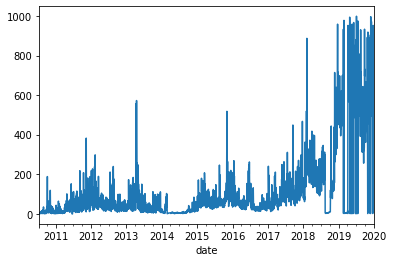

In [ ]:
bit_train['Vol.'].sort_index().plot()

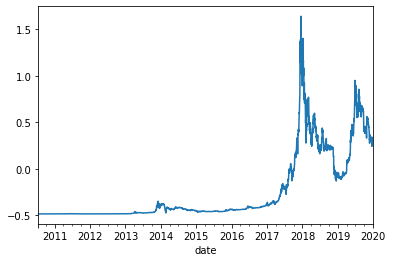

In [ ]:
bit_train.Price.sort_index().plot()

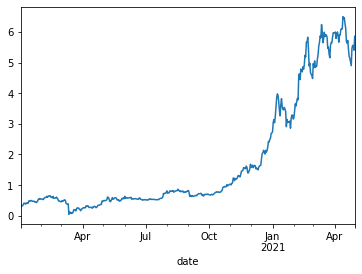

In [ ]:
bit_test.Price.sort_index().plot()

In [ ]:
def prep_time_series(df, input_ts=30, output_ts=1):
  X_train = []
  y_train = []

  df = df.sort_index()
  for i in tqdm(range(len(df)-input_ts-output_ts) ):
    X_train.append(df.iloc[i: i+input_ts]['Price'])
    y_train.append(df.iloc[i+input_ts: i+input_ts+output_ts]['Price'].values)

  return np.array(X_train), np.array(y_train)

In [ ]:
X_train, y_train = prep_time_series(bit_train, input_ts=7)
y_train = y_train.reshape(-1,)
X_test, y_test = prep_time_series(bit_test, input_ts=7)
y_test = y_test.reshape(-1,)

## Trying different models for prediction

In [ ]:
def accuracy(y_hat, y_test, alpha=.05):
  error = np.abs(y_test.flatten() - y_hat)
  error_rate = error/y_test.flatten()
  res = error_rate < alpha

  return res.sum()/res.shape[0]

In [ ]:
def res_report(y_test, y_hat):
  y_hat = scaler.inverse_transform(y_hat)
  y_test = scaler.inverse_transform(y_test)
  print('RMSE : ', mean_squared_error(y_test, y_hat, squared=False))
  print('--------------------------------------------------------------')
  print('accuracy with 5% error : ', accuracy(y_test, y_hat))

In [ ]:
X_train.shape

(3447, 7)

### Random Forest

In [ ]:
rf_reg = RandomForestRegressor()
parameters = {'n_estimators':[10, 50, 100, 200, 500], 'min_samples_split':[10, 20, 50], 'max_depth':[3, 5, 7]}
grid_reg = GridSearchCV(rf_reg, parameters)
grid_reg.fit(X_train, y_train)
sorted(grid_reg.cv_results_)

['mean_fit_time',
 'mean_score_time',
 'mean_test_score',
 'param_max_depth',
 'param_min_samples_split',
 'param_n_estimators',
 'params',
 'rank_test_score',
 'split0_test_score',
 'split1_test_score',
 'split2_test_score',
 'split3_test_score',
 'split4_test_score',
 'std_fit_time',
 'std_score_time',
 'std_test_score']

In [ ]:
print(grid_reg.cv_results_['param_max_depth'])
print(grid_reg.cv_results_['param_min_samples_split'])
print(grid_reg.cv_results_['param_n_estimators'])
print(grid_reg.cv_results_['mean_test_score'])

[3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 7 7 7 7 7 7 7
 7 7 7 7 7 7 7 7]
[10 10 10 10 10 20 20 20 20 20 50 50 50 50 50 10 10 10 10 10 20 20 20 20
 20 50 50 50 50 50 10 10 10 10 10 20 20 20 20 20 50 50 50 50 50]
[10 50 100 200 500 10 50 100 200 500 10 50 100 200 500 10 50 100 200 500
 10 50 100 200 500 10 50 100 200 500 10 50 100 200 500 10 50 100 200 500
 10 50 100 200 500]
[-4.60844047e+02 -4.52998709e+02 -4.56324860e+02 -4.55161361e+02
 -4.55683128e+02 -4.45382789e+02 -4.52538186e+02 -4.53154692e+02
 -4.55581775e+02 -4.53013574e+02 -4.60448886e+02 -4.61847071e+02
 -4.54898841e+02 -4.52019540e+02 -4.53677601e+02 -3.96667559e-01
 -3.57942995e-01 -3.79067703e-01 -3.99998788e-01 -3.87581980e-01
 -4.44048921e-01 -3.87640469e-01 -3.96605593e-01 -4.07650054e-01
 -4.00298986e-01 -3.67389222e-01 -4.76604126e-01 -4.31470353e-01
 -4.35739824e-01 -4.34070660e-01  4.40016081e-01  4.02699772e-01
  3.96117433e-01  4.11708960e-01  4.08379279e-01  4.21573299e-01
  3.85388562e-01  

In [ ]:
grid_reg.best_estimator_

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=7, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=10, min_weight_fraction_leaf=0.0,
                      n_estimators=10, n_jobs=None, oob_score=False,
                      random_state=None, verbose=0, warm_start=False)

In [ ]:
res_report(y_test, grid_reg.best_estimator_.predict(X_test))

RMSE :  16329.027051500707
--------------------------------------------------------------
accuracy with 5% error :  0.5397489539748954


### MLP Regessor

In [ ]:
nn_reg = MLPRegressor(max_iter=500).fit(X_train, y_train)

In [ ]:
res_report(y_test, nn_reg.predict(X_test))

RMSE :  4637.311646596395
--------------------------------------------------------------
accuracy with 5% error :  0.5585774058577406


### Gradient Boosting

In [ ]:
gb = GradientBoostingRegressor(n_estimators=50, max_depth=2, learning_rate=0.1).fit(X_train, y_train)

In [ ]:
res_report(y_test, gb.predict(X_test))

RMSE :  16112.93608767365
--------------------------------------------------------------
accuracy with 5% error :  0.5878661087866108


### XgBoost

In [ ]:
xgb = XGBRegressor().fit(X_train, y_train)

[13:52:42] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


In [ ]:
res_report(y_test, xgb.predict(X_test))

RMSE :  16443.322527470613
--------------------------------------------------------------
accuracy with 5% error :  0.5732217573221757


### AdaBoost

In [ ]:
ada = AdaBoostRegressor()

In [ ]:
ada = AdaBoostRegressor(n_estimators=100).fit(X_train, y_train)
parameters = {'n_estimators':[10, 50, 100, 200, 500], 'learning_rate':[1, .1, .01], 'loss':['linear', 'square']}
grid_ada = GridSearchCV(ada, parameters, scoring='r2')
grid_ada.fit(X_train, y_train)
sorted(grid_ada.cv_results_)

['mean_fit_time',
 'mean_score_time',
 'mean_test_score',
 'param_learning_rate',
 'param_loss',
 'param_n_estimators',
 'params',
 'rank_test_score',
 'split0_test_score',
 'split1_test_score',
 'split2_test_score',
 'split3_test_score',
 'split4_test_score',
 'std_fit_time',
 'std_score_time',
 'std_test_score']

In [ ]:
grid_ada.best_estimator_

AdaBoostRegressor(base_estimator=None, learning_rate=0.01, loss='square',
                  n_estimators=50, random_state=None)

In [ ]:
res_report(y_test, ada.predict(X_test))

RMSE :  15761.331683344924
--------------------------------------------------------------
accuracy with 5% error :  0.5460251046025104


### SVM Regression

In [ ]:
svm_reg = SVR().fit(X_train, y_train)

In [ ]:
res_report(y_test, svm_reg.predict(X_test))

RMSE :  19797.625679009638
--------------------------------------------------------------
accuracy with 5% error :  0.5711297071129707


### Vanilla RNN

In [ ]:
lookback = 7
X_train, y_train = prep_time_series(bit_train, input_ts=lookback)
y_train = y_train.reshape(-1, 1)
X_train = X_train.reshape(-1,lookback, 1)
X_test, y_test = prep_time_series(bit_test, input_ts=lookback)
y_test = y_test.reshape(-1, 1)
X_test = X_test.reshape(-1,lookback, 1)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=.2, shuffle=False)

In [ ]:
from torch.utils.data import TensorDataset, DataLoader

batch_size = 64

train_features = torch.Tensor(X_train)
train_targets = torch.Tensor(y_train)
val_features = torch.Tensor(X_val)
val_targets = torch.Tensor(y_val)
test_features = torch.Tensor(X_test)
test_targets = torch.Tensor(y_test)

train = TensorDataset(train_features, train_targets)
val = TensorDataset(val_features, val_targets)
test = TensorDataset(test_features, test_targets)

train_loader = DataLoader(train, batch_size=batch_size, shuffle=False, drop_last=True)
val_loader = DataLoader(val, batch_size=batch_size, shuffle=False, drop_last=True)
test_loader = DataLoader(test, batch_size=batch_size, shuffle=False, drop_last=True)
test_loader_one = DataLoader(test, batch_size=1, shuffle=False, drop_last=True)

In [ ]:
class Optimization:
    def __init__(self, model, loss_fn, optimizer):
        self.model = model
        self.loss_fn = loss_fn
        self.optimizer = optimizer
        self.train_losses = []
        self.val_losses = []
    
    def diff(self, seq, increase_only=False):
        shift = torch.zeros(seq.shape)
        shift[:, 1:, :] = seq[:, 0:-1, :]
        res =  seq - shift 
        res = res[:, 1:, :]
        x_diff = res[:, :-1, :]
        y_diff = res[:, -1, :]
        if increase_only:
          x_diff = (x_diff > 0).float()
          y_diff = (y_diff > 0).float()
        return x_diff, y_diff

    def train_step(self, x, y):
        # Sets model to train mode
        self.model.train()

        # Makes predictions
        yhat = self.model(x)

        # Computes loss
        # print(y.shape)
        # print(yhat.shape)
        loss = self.loss_fn(yhat, y)

        # Computes gradients
        loss.backward()

        # Updates parameters and zeroes gradients
        self.optimizer.step()
        self.optimizer.zero_grad()

        # Returns the loss
        return loss.item()

    def train(self, train_loader, val_loader, batch_size=64, n_epochs=50, n_features=1, n_input=7, min_max_window=False, diff=False, fc=False, increase_only=False, cnn=False):

        for epoch in range(1, n_epochs + 1):
            batch_losses = []
            for x_batch, y_batch in train_loader:
                ### min max scale each window
                if min_max_window:
                    scaler = MinMaxScaler()
                    x_batch = torch.tensor(scaler.fit_transform(x_batch.reshape(-1, n_input).T).T.reshape(-1, n_input, 1), dtype=torch.float).cuda()
                    y_batch = y_batch.cuda()
                    # y_batch = torch.tensor(scaler.transform(y_batch.reshape(-1, 1).T).T, dtype=torch.float)
                ### convert window to difference with the previous day
                elif diff:
                    full_batch = torch.cat((x_batch, y_batch.unsqueeze(-1)), 1)
                    x_batch, y_batch = self.diff(full_batch, increase_only)
                    x_batch = x_batch.cuda()
                    y_batch = y_batch.cuda()
                ### reshape input for fully connected networks
                elif fc:
                    x_batch = x_batch.reshape(-1, n_input).cuda()
                    y_batch = y_batch.cuda()
                ### reshape input for cnn
                elif cnn:
                    x_batch = x_batch.view([batch_size, n_features, -1]).cuda()
                    y_batch = y_batch.cuda()
                else:
                    x_batch = x_batch.view([batch_size, -1, n_features]).cuda()
                    y_batch = y_batch.cuda()
                loss = self.train_step(x_batch, y_batch)
                batch_losses.append(loss)
            training_loss = np.mean(batch_losses)
            self.train_losses.append(training_loss)

            with torch.no_grad():
                batch_val_losses = []
                for x_val, y_val in val_loader:
                    ### min max scale each window
                    if min_max_window:
                        scaler = MinMaxScaler()
                        x_val = torch.tensor(scaler.fit_transform(x_val.reshape(-1, n_input).T).T.reshape(-1, n_input, 1), dtype=torch.float).cuda()
                        y_val = y_val.cuda()
                        # y_val = torch.tensor(scaler.transform(y_val.reshape(-1, 1).T).T, dtype=torch.float).cuda()
                    ### convert window to difference with the previous day
                    elif diff:
                        full_batch = torch.cat((x_val, y_val.unsqueeze(-1)), 1)
                        x_val, y_val = self.diff(full_batch, increase_only)
                        x_val = x_val.cuda()
                        y_val = y_val.cuda()
                    ### reshape input for fully connected networks
                    elif fc:
                        x_val = x_val.view([batch_size, -1, n_features]).reshape(-1, n_input).cuda()
                        y_val = y_val.cuda()
                    ### reshape input for cnn
                    elif cnn:
                        x_val = x_val.view([batch_size, n_features, -1]).cuda()
                        y_val = y_val.cuda()
                    else:
                        x_val = x_val.view([batch_size, -1, n_features]).cuda()
                        y_val = y_val.cuda()


                    self.model.eval()
                    yhat = self.model(x_val)
                    val_loss = self.loss_fn(yhat, y_val).item()
                    batch_val_losses.append(val_loss)
                validation_loss = np.mean(batch_val_losses)
                self.val_losses.append(validation_loss)

            if (epoch <= 10) | (epoch % 50 == 0):
                print(
                    f"[{epoch}/{n_epochs}] Training loss: {training_loss:.4f}\t Validation loss: {validation_loss:.4f}"
                )


    def evaluate(self, test_loader, batch_size=1, n_features=1, n_input=7, min_max_window=False, diff=False, fc=False, increase_only=False, cnn=False):
        with torch.no_grad():
            predictions = []
            values = []
            for xb, yb in test_loader:
                ### min max scale each window
                if min_max_window:
                    scaler = MinMaxScaler()
                    xb = torch.tensor(scaler.fit_transform(xb.reshape(-1, n_input).T).T.reshape(-1, n_input, 1), dtype=torch.float).cuda()
                    yb = yb.cuda()
                    # yb = torch.tensor(scaler.transform(yb.reshape(-1, 1).T).T, dtype=torch.float).cuda()
                ### convert window to difference with the previous day
                elif diff:
                    full_batch = torch.cat((xb, yb.unsqueeze(-1)), 1)
                    xb, yb = self.diff(full_batch, increase_only)
                    xb = xb.cuda()
                    yb = yb.cuda()
                ### reshape input for fully connected networks
                elif fc:
                    xb = xb.view([batch_size, -1, n_features]).reshape(-1, n_input).cuda()
                    yb = yb.cuda()
                ### reshape input for cnn
                elif cnn:
                    xb = xb.view([batch_size, n_features, -1]).cuda()
                    yb = yb.cuda()
                else:
                    xb = xb.view([batch_size, -1, n_features]).cuda()
                    yb = yb.cuda()


                self.model.eval()
                yhat = self.model(xb)
                
                predictions.append(yhat.cpu().detach().numpy())
                values.append(yb.cpu().detach().numpy())

        return predictions, values

    def plot_losses(self):
        plt.plot(self.train_losses, label="Training loss")
        plt.plot(self.val_losses, label="Validation loss")
        plt.legend()
        plt.title("Losses")
        plt.show()
        plt.close()

In [ ]:
def inverse_transform(scaler, df, columns):
    for col in columns:
        df[col] = scaler.inverse_transform(df[col])
    return df


def format_predictions(predictions, values, df_test, scaler):
    vals = np.concatenate(values, axis=0).ravel()
    preds = np.concatenate(predictions, axis=0).ravel()
    df_result = pd.DataFrame(data={"value": vals, "prediction": preds})
    df_result = df_result.sort_index()
    if scaler:
      df_result = inverse_transform(scaler, df_result, [["value", "prediction"]])
    return df_result

In [ ]:
def calculate_metrics(df):
    return {'mae' : mean_absolute_error(df.value, df.prediction),
            'rmse' : mean_squared_error(df.value, df.prediction) ** 0.5,
            'r2' : r2_score(df.value, df.prediction),
            'accuracy': accuracy(np.array(df.value), np.array(df.prediction))}

In [ ]:
class RNNModel(nn.Module):
    def __init__(self, input_dim, hidden_dim, layer_dim, output_dim, dropout_prob):
        super(RNNModel, self).__init__()

        # Defining the number of layers and the nodes in each layer
        self.hidden_dim = hidden_dim
        self.layer_dim = layer_dim

        # RNN layers
        self.rnn = nn.RNN(
            input_dim, hidden_dim, layer_dim, batch_first=True, dropout=dropout_prob
        )
        # Fully connected layer
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        h0 = torch.zeros(self.layer_dim, x.size(0), self.hidden_dim).requires_grad_()

        out, h0 = self.rnn(x, h0.cuda().detach())
        out = out[:, -1, :]

        out = self.fc(torch.relu(out))
        return out

[1/500] Training loss: 0.2318	 Validation loss: 0.2665
[2/500] Training loss: 0.1164	 Validation loss: 0.4136
[3/500] Training loss: 0.0826	 Validation loss: 0.5034
[4/500] Training loss: 0.0731	 Validation loss: 0.5433
[5/500] Training loss: 0.0703	 Validation loss: 0.5574
[6/500] Training loss: 0.0691	 Validation loss: 0.5591
[7/500] Training loss: 0.0687	 Validation loss: 0.5556
[8/500] Training loss: 0.0672	 Validation loss: 0.5468
[9/500] Training loss: 0.0631	 Validation loss: 0.5223
[10/500] Training loss: 0.0425	 Validation loss: 0.4248
[50/500] Training loss: 0.0042	 Validation loss: 0.0138
[100/500] Training loss: 0.0039	 Validation loss: 0.0257
[150/500] Training loss: 0.0034	 Validation loss: 0.0085
[200/500] Training loss: 0.0033	 Validation loss: 0.0035
[250/500] Training loss: 0.0034	 Validation loss: 0.0042
[300/500] Training loss: 0.0027	 Validation loss: 0.0029
[350/500] Training loss: 0.0026	 Validation loss: 0.0028
[400/500] Training loss: 0.0025	 Validation loss: 0

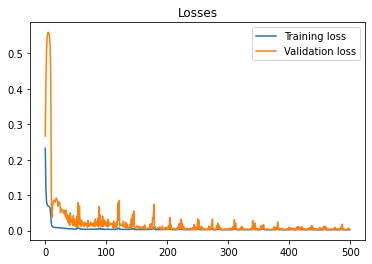

In [ ]:
input_dim = 1
output_dim = 1
hidden_dim = 5
layer_dim = 3
batch_size = 64
dropout = 0.2
n_epochs = 500
learning_rate = 1e-3
weight_decay = 1e-6

model = RNNModel(input_dim, hidden_dim, layer_dim, output_dim, dropout)

model = model.cuda()
loss_fn = nn.MSELoss(reduction="mean")
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)

opt = Optimization(model=model, loss_fn=loss_fn, optimizer=optimizer)
opt.train(train_loader, val_loader, batch_size=batch_size, n_epochs=n_epochs, n_features=input_dim)
opt.plot_losses()

predictions, values = opt.evaluate(test_loader_one, batch_size=1, n_features=input_dim)

In [ ]:
df_result = format_predictions(predictions, values, X_test, scaler)
result_metrics = calculate_metrics(df_result)

In [ ]:
result_metrics

{'accuracy': 0.34309623430962344,
 'mae': 8749.804,
 'r2': 0.04992557369663353,
 'rmse': 16770.633381002637}

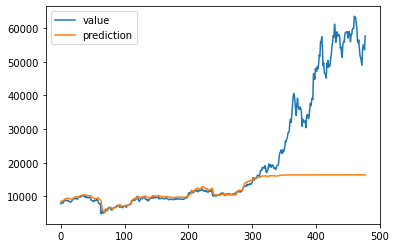

In [ ]:
df_result.plot()

### LSTM

In [ ]:
class LSTMModel(nn.Module):

    def __init__(self, input_dim, hidden_dim, layer_dim, output_dim, dropout_prob):

        super(LSTMModel, self).__init__()

        # Defining the number of layers and the nodes in each layer
        self.hidden_dim = hidden_dim
        self.layer_dim = layer_dim

        # LSTM layers
        self.lstm = nn.LSTM(
            input_dim, hidden_dim, layer_dim, batch_first=True, dropout=dropout_prob
        )

        # Fully connected layer
        self.fc = nn.Linear(hidden_dim, output_dim)

        self.scaler = StandardScaler()

    def forward(self, x):

        h0 = torch.zeros(self.layer_dim, x.size(0), self.hidden_dim).requires_grad_()

        c0 = torch.zeros(self.layer_dim, x.size(0), self.hidden_dim).requires_grad_()
        out, (hn, cn) = self.lstm(x, (h0.cuda().detach(), c0.cuda().detach()))
        out = out[:, -1, :]

        out = self.fc(torch.relu(out))
        
        return out

[1/500] Training loss: 0.0742	 Validation loss: 0.6052
[2/500] Training loss: 0.0675	 Validation loss: 0.5721
[3/500] Training loss: 0.0673	 Validation loss: 0.5559
[4/500] Training loss: 0.0666	 Validation loss: 0.5434
[5/500] Training loss: 0.0653	 Validation loss: 0.5276
[6/500] Training loss: 0.0622	 Validation loss: 0.4954
[7/500] Training loss: 0.0571	 Validation loss: 0.4322
[8/500] Training loss: 0.0503	 Validation loss: 0.3472
[9/500] Training loss: 0.0416	 Validation loss: 0.2490
[10/500] Training loss: 0.0317	 Validation loss: 0.1532
[50/500] Training loss: 0.0082	 Validation loss: 0.1191
[100/500] Training loss: 0.0030	 Validation loss: 0.0117
[150/500] Training loss: 0.0024	 Validation loss: 0.0111
[200/500] Training loss: 0.0018	 Validation loss: 0.0031
[250/500] Training loss: 0.0016	 Validation loss: 0.0040
[300/500] Training loss: 0.0030	 Validation loss: 0.0155
[350/500] Training loss: 0.0016	 Validation loss: 0.0066
[400/500] Training loss: 0.0014	 Validation loss: 0

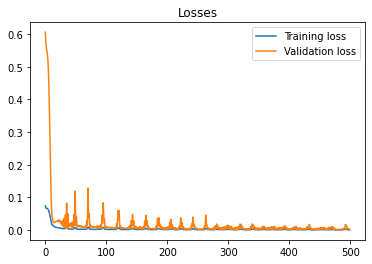

In [ ]:
input_dim = 1
output_dim = 1
hidden_dim = 10
layer_dim = 3
batch_size = 64
dropout = 0.2
n_epochs = 500
learning_rate = 1e-3
weight_decay = 1e-6

model = LSTMModel(input_dim, hidden_dim, layer_dim, output_dim, dropout)

model = model.cuda()
loss_fn = nn.MSELoss(reduction="mean")
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)

opt = Optimization(model=model, loss_fn=loss_fn, optimizer=optimizer)
opt.train(train_loader, val_loader, batch_size=batch_size, n_epochs=n_epochs, n_features=input_dim)
opt.plot_losses()

predictions, values = opt.evaluate(test_loader_one, batch_size=1, n_features=input_dim)

In [ ]:
df_result = format_predictions(predictions, values, X_test, scaler)
result_metrics = calculate_metrics(df_result)

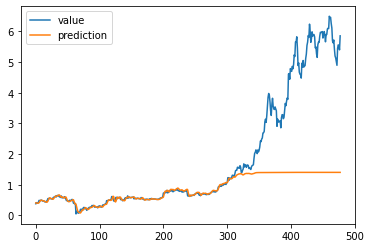

In [ ]:
df_result.plot()

In [ ]:
result_metrics

{'accuracy': 0.401673640167364,
 'mae': 0.91858786,
 'r2': 0.09154286159127223,
 'rmse': 1.8018581124690987}

### GRU

In [ ]:
class GRUModel(nn.Module):
    def __init__(self, input_dim, hidden_dim, layer_dim, output_dim, dropout_prob):

        super(GRUModel, self).__init__()

        # Defining the number of layers and the nodes in each layer
        self.layer_dim = layer_dim
        self.hidden_dim = hidden_dim

        # GRU layers
        self.gru = nn.GRU(
            input_dim, hidden_dim, layer_dim, batch_first=True, dropout=dropout_prob
        )

        # Fully connected layer
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):

        h0 = torch.zeros(self.layer_dim, x.size(0), self.hidden_dim).requires_grad_()

        out, _ = self.gru(x, h0.cuda().detach())
        out = out[:, -1, :]

        out = self.fc(torch.relu(out))

        return out


[1/500] Training loss: 0.3398	 Validation loss: 0.4067
[2/500] Training loss: 0.0887	 Validation loss: 0.6018
[3/500] Training loss: 0.0762	 Validation loss: 0.5726
[4/500] Training loss: 0.0773	 Validation loss: 0.5723
[5/500] Training loss: 0.0763	 Validation loss: 0.5670
[6/500] Training loss: 0.0757	 Validation loss: 0.5625
[7/500] Training loss: 0.0742	 Validation loss: 0.5563
[8/500] Training loss: 0.0731	 Validation loss: 0.5494
[9/500] Training loss: 0.0706	 Validation loss: 0.5349
[10/500] Training loss: 0.0677	 Validation loss: 0.5080
[50/500] Training loss: 0.0085	 Validation loss: 0.0379
[100/500] Training loss: 0.0054	 Validation loss: 0.0340
[150/500] Training loss: 0.0045	 Validation loss: 0.0118
[200/500] Training loss: 0.0044	 Validation loss: 0.0303
[250/500] Training loss: 0.0038	 Validation loss: 0.0084
[300/500] Training loss: 0.0036	 Validation loss: 0.0059
[350/500] Training loss: 0.0027	 Validation loss: 0.0078
[400/500] Training loss: 0.0029	 Validation loss: 0

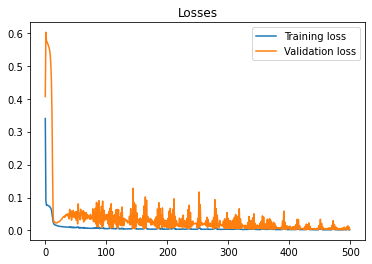

In [ ]:
input_dim = 1
output_dim = 1
hidden_dim = 7
layer_dim = 5
batch_size = 64
dropout = 0.2
n_epochs = 500
learning_rate = 1e-3
weight_decay = 1e-6

model = GRUModel(input_dim, hidden_dim, layer_dim, output_dim, dropout)

model = model.cuda()
loss_fn = nn.MSELoss(reduction="mean")
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)

opt = Optimization(model=model, loss_fn=loss_fn, optimizer=optimizer)
opt.train(train_loader, val_loader, batch_size=batch_size, n_epochs=n_epochs, n_features=input_dim)
opt.plot_losses()

predictions, values = opt.evaluate(test_loader_one, batch_size=1, n_features=input_dim)

In [ ]:
df_result = format_predictions(predictions, values, X_test, scaler)
result_metrics = calculate_metrics(df_result)

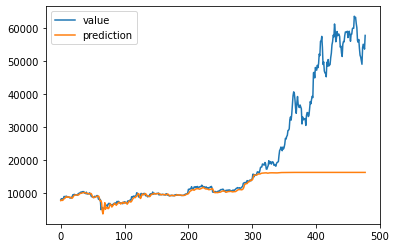

In [ ]:
df_result.plot()

In [ ]:
result_metrics

{'accuracy': 0.45397489539748953,
 'mae': 8759.393,
 'r2': 0.03436745996878088,
 'rmse': 16907.391046521636}

### Torch NN

In [ ]:
class Net(torch.nn.Module):
  def __init__(self):
    super(Net, self).__init__()
    self.hid1 = torch.nn.Linear(7, 10) 
    self.hid2 = torch.nn.Linear(10, 20)
    self.hid3 = torch.nn.Linear(20, 20)
    self.hid4 = torch.nn.Linear(20, 10)
    self.oupt = torch.nn.Linear(10, 1)

    torch.nn.init.xavier_uniform_(self.hid1.weight)
    torch.nn.init.zeros_(self.hid1.bias)
    torch.nn.init.xavier_uniform_(self.hid2.weight)
    torch.nn.init.zeros_(self.hid2.bias)
    torch.nn.init.xavier_uniform_(self.oupt.weight)
    torch.nn.init.zeros_(self.oupt.bias)
    torch.nn.init.xavier_uniform_(self.hid3.weight)
    torch.nn.init.zeros_(self.hid3.bias)
    torch.nn.init.xavier_uniform_(self.hid4.weight)
    torch.nn.init.zeros_(self.hid4.bias)

  def forward(self, x):
    z = torch.relu(self.hid1(x))
    z = torch.relu(self.hid2(z))
    z = torch.relu(self.hid3(z))
    z = torch.relu(self.hid4(z))
    z = self.oupt(z)
    return z

[1/500] Training loss: 0.1703	 Validation loss: 0.1818
[2/500] Training loss: 0.0381	 Validation loss: 0.1871
[3/500] Training loss: 0.0210	 Validation loss: 0.1327
[4/500] Training loss: 0.0168	 Validation loss: 0.0957
[5/500] Training loss: 0.0122	 Validation loss: 0.0617
[6/500] Training loss: 0.0081	 Validation loss: 0.0358
[7/500] Training loss: 0.0044	 Validation loss: 0.0137
[8/500] Training loss: 0.0020	 Validation loss: 0.0036
[9/500] Training loss: 0.0012	 Validation loss: 0.0051
[10/500] Training loss: 0.0010	 Validation loss: 0.0047
[50/500] Training loss: 0.0011	 Validation loss: 0.0057
[100/500] Training loss: 0.0009	 Validation loss: 0.0056
[150/500] Training loss: 0.0008	 Validation loss: 0.0050
[200/500] Training loss: 0.0008	 Validation loss: 0.0047
[250/500] Training loss: 0.0008	 Validation loss: 0.0047
[300/500] Training loss: 0.0007	 Validation loss: 0.0045
[350/500] Training loss: 0.0007	 Validation loss: 0.0043
[400/500] Training loss: 0.0007	 Validation loss: 0

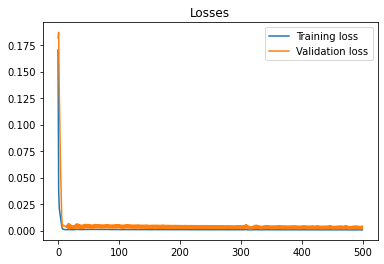

In [ ]:
batch_size = 64
dropout = 0.2
n_epochs = 500
learning_rate = 1e-3
weight_decay = 1e-6

model = Net()

model = model.cuda()
loss_fn = nn.MSELoss(reduction="mean")
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)

opt = Optimization(model=model, loss_fn=loss_fn, optimizer=optimizer)
opt.train(train_loader, val_loader, batch_size=batch_size, n_epochs=n_epochs, n_features=1, fc=True)
opt.plot_losses()

predictions, values = opt.evaluate(test_loader_one, batch_size=1, n_features=1, fc=True)

In [ ]:
df_result = format_predictions(predictions, values, X_test, scaler)
result_metrics = calculate_metrics(df_result)

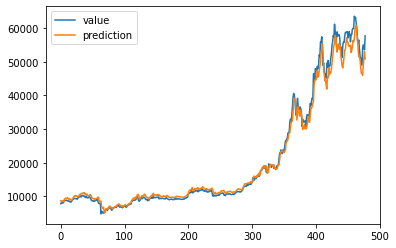

In [ ]:
df_result.plot()

In [ ]:
result_metrics  

{'accuracy': 0.401673640167364,
 'mae': 1209.265,
 'r2': 0.988426158422957,
 'rmse': 1851.0127633271468}

### CNN

In [ ]:
class CNN_ForecastNet(nn.Module):
    def __init__(self):
        super(CNN_ForecastNet,self).__init__()
        self.conv1 = nn.Conv1d(1,3, kernel_size = 3, stride = 1, padding =1)
        self.bn1 = nn.BatchNorm1d(3)
        self.maxpool1 = nn.MaxPool1d(kernel_size=3, stride=1, padding=1)
        self.dropout1 = nn.Dropout(0.3)
        
        self.conv2 = nn.Conv1d(3, 5, kernel_size=3, stride=2, padding=1)
        self.bn2 = nn.BatchNorm1d(5)
        self.dropout2 = nn.Dropout(0.3)
        
        self.conv3 = nn.Conv1d(5, 10, kernel_size=3, stride=1, padding=1)
        self.bn3 = nn.BatchNorm1d(10)
        self.dropout3 = nn.Dropout(0.3)
        
        self.fc = nn.Linear(10, 1)
          
    def forward(self,x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = torch.relu(x)

        x = self.maxpool1(x)
        x = self.dropout1(x)

        x = self.conv2(x)
        x = self.bn2(x)
        x = torch.relu(x)

        x = self.dropout2(x)

        x = self.conv3(x)
        x = self.bn3(x)
        x = torch.relu(x)

        x = self.dropout3(x)
        x = torch.mean(x, dim = 2)
        x = self.fc(x)
        
        return x

[1/100] Training loss: 0.9277	 Validation loss: 0.2508
[2/100] Training loss: 0.5155	 Validation loss: 0.8293
[3/100] Training loss: 0.3022	 Validation loss: 0.2130
[4/100] Training loss: 0.1687	 Validation loss: 0.1148
[5/100] Training loss: 0.0983	 Validation loss: 0.1347
[6/100] Training loss: 0.0617	 Validation loss: 0.1746
[7/100] Training loss: 0.0459	 Validation loss: 0.2903
[8/100] Training loss: 0.0386	 Validation loss: 0.3020
[9/100] Training loss: 0.0363	 Validation loss: 0.3639
[10/100] Training loss: 0.0345	 Validation loss: 0.3172
[50/100] Training loss: 0.0172	 Validation loss: 0.7902
[100/100] Training loss: 0.0048	 Validation loss: 0.3983


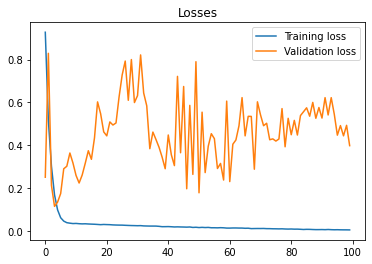

In [ ]:
batch_size = 64
dropout = 0.2
n_epochs = 100
learning_rate = 1e-3
weight_decay = 1e-6

model = CNN_ForecastNet()

model = model.cuda()
loss_fn = nn.MSELoss(reduction="mean")
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)

opt = Optimization(model=model, loss_fn=loss_fn, optimizer=optimizer)
opt.train(train_loader, val_loader, batch_size=batch_size, n_epochs=n_epochs, n_features=1, cnn=True)
opt.plot_losses()

predictions, values = opt.evaluate(test_loader_one, batch_size=1, n_features=1, cnn=True)

In [ ]:
df_result = format_predictions(predictions, values, X_test, scaler)
result_metrics = calculate_metrics(df_result)

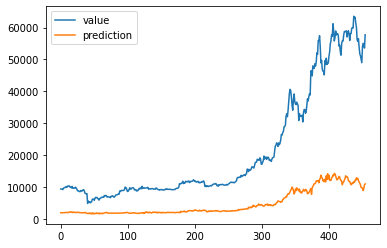

In [ ]:
df_result.plot()

In [ ]:
result_metrics

{'accuracy': 0.01098901098901099,
 'mae': 12332.331,
 'r2': -0.04866431265727944,
 'rmse': 17842.40611576813}

## Ensemble Learning

### Stacking

In [ ]:
estimators = [
    ('rf', RandomForestRegressor()),
    ('xgb', XGBRegressor()),
    ('gb', GradientBoostingRegressor()),
    ('ada', AdaBoostRegressor()), 
    ('svr', SVR())
]
ens = StackingRegressor(
    estimators=estimators,
    final_estimator=MLPRegressor(),
    passthrough=True
)

ens = ens.fit(X_train, y_train)

[15:40:11] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[15:40:19] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[15:40:19] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[15:40:19] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[15:40:19] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[15:40:19] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


In [ ]:
res_report(y_test, ens.predict(X_test))

RMSE :  4594.954621296016
--------------------------------------------------------------
accuracy with 5% error :  0.5


### Bagging

In [ ]:
def subsample(dataset_x, dataset_y, ratio=1.0):
    sample_x = []
    sample_y = []
    n_sample = round(len(dataset_x) * ratio)
    while len(sample_x) < n_sample:
      index = randrange(len(dataset_x))
      sample_x.append(dataset_x[index])
      sample_y.append(dataset_y[index])
    return np.array(sample_x), np.array(sample_y)

In [ ]:
def stack_results(models, X):
  preds_data = []
  for i in range(len(models)):
    preds_data.append(models[i].predict(X))
  final_data = np.vstack(preds_data).T

  return final_data

def bagging(estimators, final_model, X_train, y_train, X_test, y_test):  
  ## training models on bootstrapped data
  models = []
  for i in range(len(estimators)):
    bootst_x, bootst_y = subsample(X_train, y_train, 0.7)
    models.append(estimators[i][1].fit(bootst_x, bootst_y))
  
  ## stacking result
  final_data = stack_results(models, X_train)
  
  ## train final model on stacked results
  final_model = final_model.fit(final_data, y_train)

  ## testing 
  test_data = stack_results(models, X_test)
  yhat = final_model.predict(test_data)

  print(res_report(y_test, yhat))


In [ ]:
bagging(estimators, MLPRegressor(), X_train, y_train, X_test, y_test)

[15:40:44] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
RMSE :  16043.237039714808
--------------------------------------------------------------
accuracy with 5% error :  0.600418410041841
None


## Bitcoin price increase classificaiton

In [ ]:
lookback = 7
X_train, y_train = prep_time_series(bit_train, input_ts=lookback)
y_train = y_train.reshape(-1, 1)
X_train = X_train.reshape(-1,lookback, 1)
X_test, y_test = prep_time_series(bit_test, input_ts=lookback)
y_test = y_test.reshape(-1, 1)
X_test = X_test.reshape(-1,lookback, 1)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=.2, shuffle=False)

In [ ]:
from torch.utils.data import TensorDataset, DataLoader

batch_size = 64

train_features = torch.Tensor(X_train)
train_targets = torch.Tensor(y_train)
val_features = torch.Tensor(X_val)
val_targets = torch.Tensor(y_val)
test_features = torch.Tensor(X_test)
test_targets = torch.Tensor(y_test)

train = TensorDataset(train_features, train_targets)
val = TensorDataset(val_features, val_targets)
test = TensorDataset(test_features, test_targets)

train_loader = DataLoader(train, batch_size=batch_size, shuffle=False, drop_last=True)
val_loader = DataLoader(val, batch_size=batch_size, shuffle=False, drop_last=True)
test_loader = DataLoader(test, batch_size=batch_size, shuffle=False, drop_last=True)
test_loader_one = DataLoader(test, batch_size=1, shuffle=False, drop_last=True)

In [ ]:
class LSTMclf(nn.Module):

    def __init__(self, input_dim, hidden_dim, layer_dim, output_dim, dropout_prob):

        super(LSTMclf, self).__init__()

        # Defining the number of layers and the nodes in each layer
        self.hidden_dim = hidden_dim
        self.layer_dim = layer_dim

        # LSTM layers
        self.lstm = nn.LSTM(
            input_dim, hidden_dim, layer_dim, batch_first=True, dropout=dropout_prob
        )

        # Fully connected layer
        self.fc = nn.Linear(hidden_dim, output_dim)

        self.scaler = StandardScaler()

    def forward(self, x):

        h0 = torch.zeros(self.layer_dim, x.size(0), self.hidden_dim).requires_grad_()

        c0 = torch.zeros(self.layer_dim, x.size(0), self.hidden_dim).requires_grad_()
        out, (hn, cn) = self.lstm(x, (h0.cuda().detach(), c0.cuda().detach()))
        out = out[:, -1, :]

        out = self.fc(torch.relu(out))
        ## add sigmoid to the output
        out = torch.sigmoid(out)

        return out.reshape(-1, 1)

[1/25] Training loss: 0.7101	 Validation loss: 0.7277
[2/25] Training loss: 0.7018	 Validation loss: 0.7175
[3/25] Training loss: 0.6979	 Validation loss: 0.7137
[4/25] Training loss: 0.6969	 Validation loss: 0.7119
[5/25] Training loss: 0.6960	 Validation loss: 0.7102
[6/25] Training loss: 0.6953	 Validation loss: 0.7087
[7/25] Training loss: 0.6946	 Validation loss: 0.7076
[8/25] Training loss: 0.6942	 Validation loss: 0.7067
[9/25] Training loss: 0.6939	 Validation loss: 0.7060
[10/25] Training loss: 0.6936	 Validation loss: 0.7053


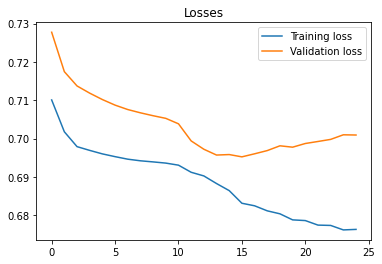

In [ ]:
input_dim = 1
output_dim = 1
hidden_dim = 7
layer_dim = 3
batch_size = 64
dropout = 0.2
n_epochs = 25
learning_rate = 1e-3
weight_decay = 1e-6

model = LSTMclf(input_dim, hidden_dim, layer_dim, output_dim, dropout)

model = model.cuda()
loss_fn = nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)

opt = Optimization(model=model, loss_fn=loss_fn, optimizer=optimizer)
opt.train(train_loader, val_loader, batch_size=batch_size, n_epochs=n_epochs, n_features=input_dim, diff=True, increase_only=True)
opt.plot_losses()

predictions, values = opt.evaluate(test_loader_one, batch_size=1, n_features=input_dim, diff=True, increase_only=True)

In [ ]:
df_result = format_predictions(predictions, values, X_test, scaler=None)

In [ ]:
df_result['res'] = (df_result.prediction > 0.5).astype(int)

In [ ]:
df_result

,value,prediction,res
0,0.0,0.531154,1
1,1.0,0.530134,1
2,0.0,0.526643,1
3,1.0,0.531041,1
4,0.0,0.528208,1
...,...,...,...
473,1.0,0.513013,1
474,1.0,0.355481,0
475,0.0,0.362797,0
476,0.0,0.394535,0


In [ ]:
(df_result.value == df_result.res).sum() / len(df_result)

0.5334728033472803

In [ ]:
df_result['value'].value_counts()

1.0    265
0.0    213
Name: value, dtype: int64

# Stock prediction

In [ ]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [ ]:
stock = pd.read_csv('/content/drive/MyDrive/Data/training_data.csv')

In [ ]:
stock.set_index('id', inplace=True)
stock.drop('data_type', axis=1, inplace=True)
stock.drop('era', axis=1, inplace=True)

In [ ]:
stock.feature_intelligence1.value_counts()

0.00    100407
1.00    100388
0.25    100338
0.75    100338
0.50    100337
Name: feature_intelligence1, dtype: int64

In [ ]:
X_train = stock[[s for s in stock.columns if s != 'target']]
y_train = stock.target

X_train, X_test, y_train, y_test = train_test_split(X_train, y_train, test_size=.2, shuffle=False)

In [ ]:
model = XGBRegressor(max_depth=5 , learning_rate=0.01, n_estimators=2000, colsample_bytree= 0.1)
model = model.fit(X_train, y_train)

[15:26:59] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


In [ ]:
print('RMSE : ', mean_squared_error(y_test, model.predict(X_test), squared=False))
print('--------------------------------------------------------------')
print('accuracy with 5% error : ', accuracy(y_test, model.predict(X_test)))

RMSE :  0.22312069615156965
--------------------------------------------------------------
accuracy with 5% error :  0.47514995715509856


In [ ]:
nn_reg = MLPRegressor(max_iter=500).fit(X_train, y_train)

In [ ]:
print('RMSE : ', mean_squared_error(y_test, nn_reg.predict(X_test), squared=False))
print('--------------------------------------------------------------')
print('accuracy with 5% error : ', accuracy(y_test, nn_reg.predict(X_test)))

RMSE :  0.22355014993065467
--------------------------------------------------------------
accuracy with 5% error :  0.472160777983699


In [ ]:
svr = SVR().fit(X_train, y_train)

In [ ]:
print('RMSE : ', mean_squared_error(y_test, svr.predict(X_test), squared=False))
print('--------------------------------------------------------------')
print('accuracy with 5% error : ', accuracy(y_test, svr.predict(X_test)))